# EDF format checks

## There are 3 potential issues related to the conversion of raw signals to EDF:

1. Signal clipping:    signal cut once it exceeds an amplitude threshold
                       (the min-max range set before EDF conversion was 
                       too narrow)
2. Bit depth:          signal shows a stair-like progression (the min-max
                       range set before EDF conversion was too wide)
3. Inverted polarity:  signal multiplied by -1 

The present script is semi-automated: for each subject and channel,
figures are plotted to make a visual inspection. Problematic files are
stored in a table.

In [1]:
# Import libraries
import os, fnmatch
import ipywidgets as widgets
import tkinter
from tkinter import filedialog
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import mne
from mne.io.constants import FIFF

import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
def show_channels_histograms(data, ch_name, ax, estimator=lambda x: x):
    unit = [ch['unit'] for ch in data.info['chs'] if ch['ch_name'] == ch_name][0]

    scaler = 1e+6 if unit == 'µV' else 1e+3
    X = data.get_data([ch_name])[0]
    X = estimator(X * scaler)

    # Plot figure
    sns.histplot(
        X,
        stat='percent',
        bins=500,
        kde=True,
        ax=ax
    )

    max_x = X.max() + abs(X.max())*0.05
    min_x = X.min() + abs(X.min())*0.05
    ax.set_xlim(min_x,max_x)
    ax.set_ylabel('Data points distribution (%)')
    ax.set_xlabel(f'Amplitude ({unit})')

In [3]:
# Path to EDF files: select folder containing the EDF files
root = tkinter.Tk()
root.withdraw()
subfolder = filedialog.askdirectory(
    parent=root,
    initialdir="./",
    title='>>> Select the folder containing the EDF files'
)

# Path to EDF files: select folder containing the EDF files
filelist = [
    (root, filename)
    for root, dirs, files in os.walk(subfolder)
    for filename in files
    if fnmatch.fnmatch(filename, '*.edf')
]
print(f'>>> {len(filelist)} EDF files found')

>>> 3 EDF files found


In [4]:
# Select the EDF file to check.
# NOTE: Selection is automatically set each time you select one or more items from
# the shown menu. Once you select the files you want to use, continue by just 
# running the following blocks. At any time you can comeback to select new items
# and re run the following blocks for that new selection.
w_files = widgets.SelectMultiple(
    options=[filename for root, filename in filelist],
    description='Select the EDF file to check',
    disabled=False
)

w_files

SelectMultiple(description='Select the EDF file to check', options=('02ZB_EEG_clipped.edf', '01HC_EEG_clean.ed…

In [13]:
# Loop across selected files

selected_files = list(filter(lambda x: x[1] in w_files.value, filelist))
datas = {}
options = []
for subfolder, subID in selected_files:

    # Import the data
    print(f'>>> >>> Importing data from Subject {subID[:-4]}...')
    file_path = os.path.join(subfolder, subID)
    datas[subID] = mne.io.read_raw_edf(
        file_path,
        preload=True,
        verbose=True
    )
    options += [f'{subID} - {ch_name}' for ch_name in datas[subID].info['ch_names']]
  
## Check for signal clipping and bit depth issue

w_channels = widgets.SelectMultiple(
    options=options,
    description='Select the EDF file and channels to check',
    disabled=False
)

w_channels

>>> >>> Importing data from Subject 02ZB_EEG_clipped...
Extracting EDF parameters from /home/laouen.belloli/Documents/git/eeg-club/data/Demo/EDF/02ZB_EEG_clipped.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fp1-A2, C3-A2, O1-A2, EMG 1-EMG 2
Creating raw.info structure...
Reading 0 ... 1965567  =      0.000 ...  7677.996 secs...
>>> >>> Importing data from Subject 01HC_EEG_clean...
Extracting EDF parameters from /home/laouen.belloli/Documents/git/eeg-club/data/Demo/EDF/01HC_EEG_clean.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fp1-A2, C3-A2, O1-A2, EMG 1-EMG 2
Creating raw.info structure...
Reading 0 ... 1599487  =      0.000 ...  6247.996 secs...


SelectMultiple(description='Select the EDF file and channels to check', options=('02ZB_EEG_clipped.edf - Fp1-A…

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

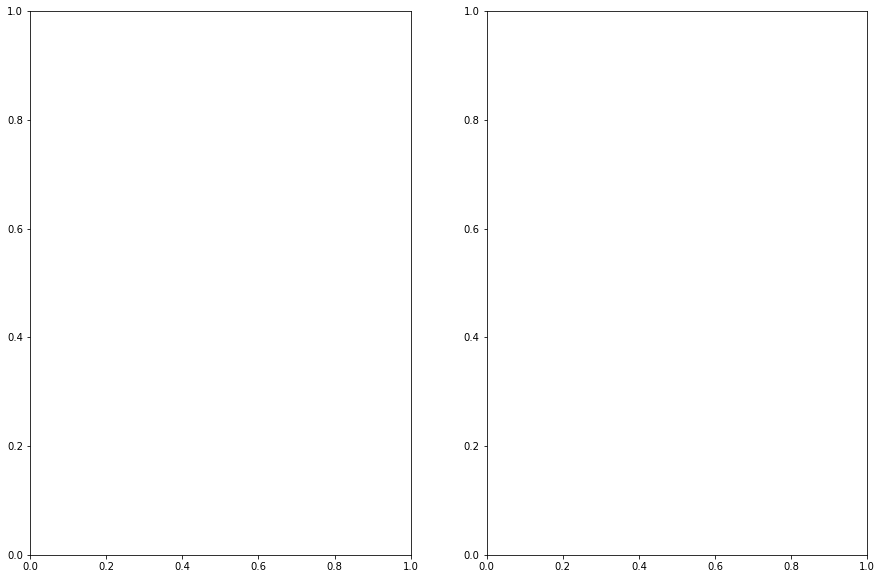

In [30]:
selected_options = [option.split(' - ') for option in w_channels.value]

for subfolder, subID in selected_files:
    selected_channels = [
        ch_name 
        for seleted_subID, ch_name in selected_options
        if seleted_subID == subID
    ]

    data = datas[subID]

    for ch_name in selected_channels:
        fig, axes = plt.subplots(1,2, figsize=(15,10))
        axes = axes.flatten()

        show_channels_histograms(data, ch_name, axes[0])
        show_channels_histograms(
            data,
            ch_name,
            axes[1],
            estimator=lambda x: np.abs(np.diff(x))
        )

        plt.title(f'{subID} ({ch_name}) Amplitude distribution')
        plt.tight_layout()
        plt.show()
        